In [65]:
# Step 1: Imports
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [66]:
# Paths
MODEL_PATH = "MapSegmentationGenerator.keras"
IMAGE_PATH = "trackTest.jpg"

In [67]:
# Step 2: Load model
model = load_model(MODEL_PATH, compile=False)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [68]:
# Step 3: Function to tile an image
def tile_image(image, tile_size=(128, 128)):
    """
    Splits an image into tiles of given size.

    Args:
        image (PIL.Image or np.ndarray): Input image.
        tile_size (tuple): (width, height) of each tile.

    Returns:
        list: List of tiles as NumPy arrays.
    """
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    width, height = image.size
    tiles = []

    # Go through image in steps
    for y in range(0, height, tile_size[1]):
        for x in range(0, width, tile_size[0]):
            # Crop tile
            tile = image.crop((x, y, x + tile_size[0], y + tile_size[1]))

            # If tile is smaller, pad it
            if tile.size != tile_size:
                new_tile = Image.new("RGB", tile_size, (0, 0, 0))
                new_tile.paste(tile, (0, 0))
                tile = new_tile

            tiles.append(np.array(tile))
    return tiles

In [69]:
# Step 4: Load and tile the image
original_image = Image.open(IMAGE_PATH).convert("RGB")
tiles = tile_image(original_image, (128, 128))

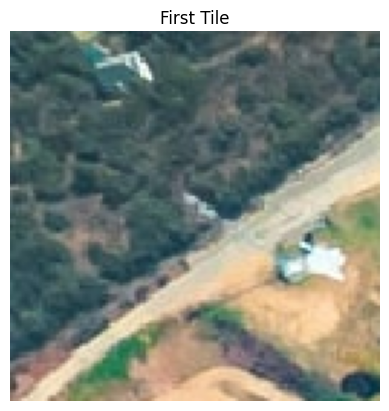

In [70]:
# Show the first tile
plt.imshow(tiles[0])
plt.title("First Tile")
plt.axis("off")
plt.show()

In [71]:
# Step 5: Predict on first tile
first_tile = np.expand_dims(tiles[0], axis=0)  # Add batch dimension
prediction = model.predict(first_tile)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step


In [72]:
# Step 6: Visualization function
def visualize_results(predicted_mask, original_image):
    predicted_mask = np.squeeze(predicted_mask)
    plt.figure(figsize=(8, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Tile')
    plt.axis('off')

    # Prediction
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray', vmin=0, vmax=1)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

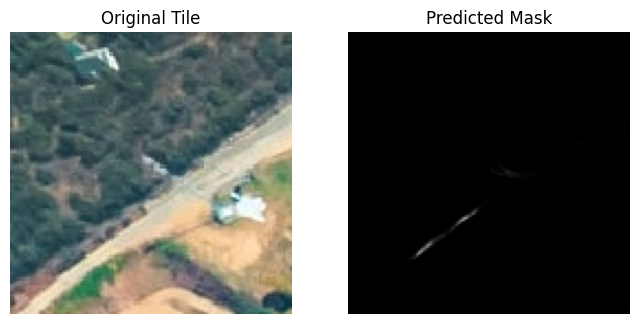

In [73]:
# Step 7: Show results for first tile
visualize_results(prediction, tiles[0])

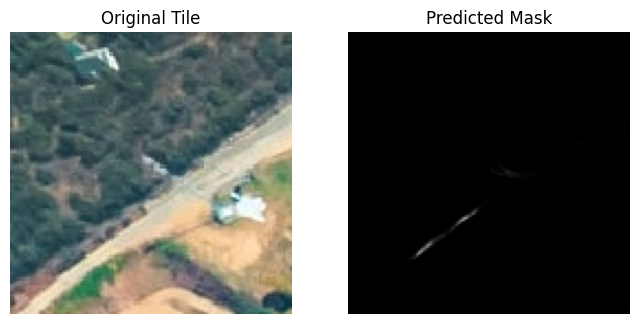

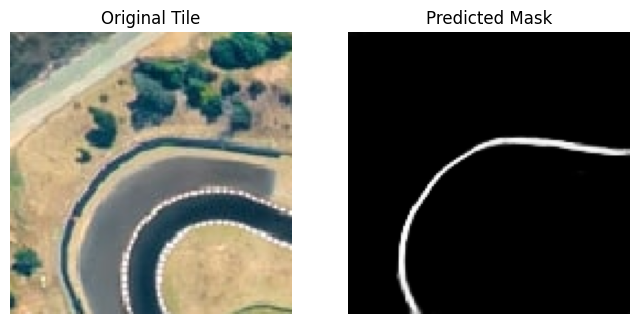

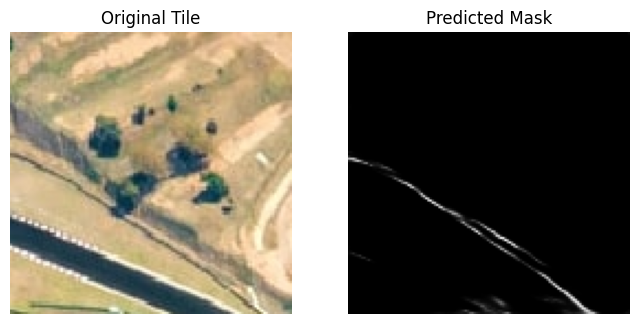

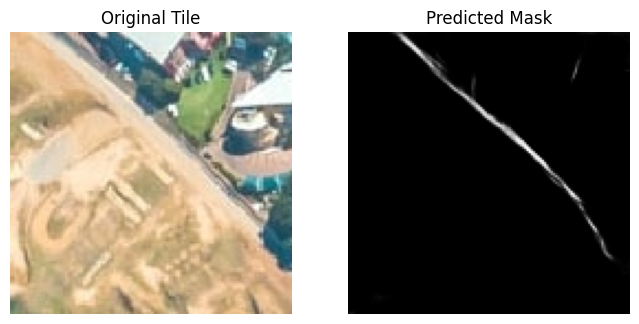

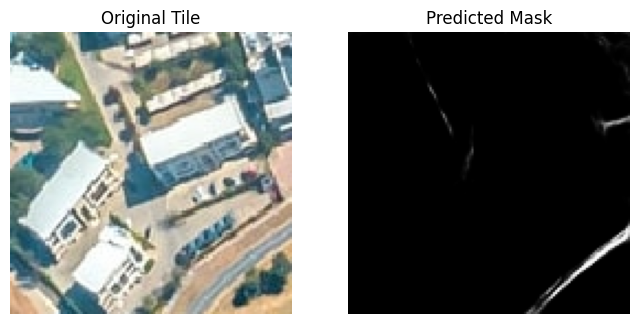

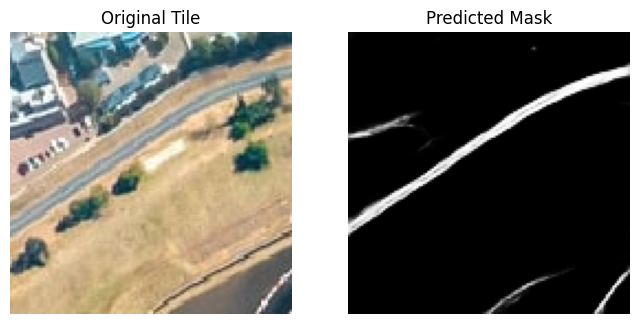

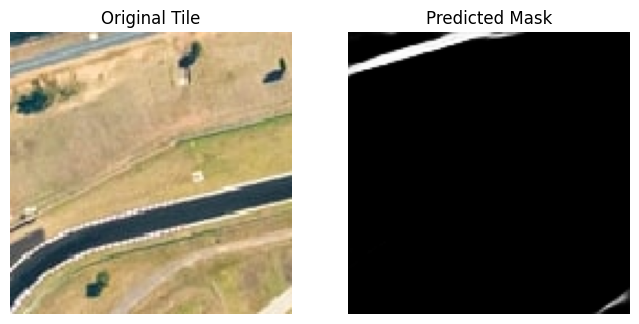

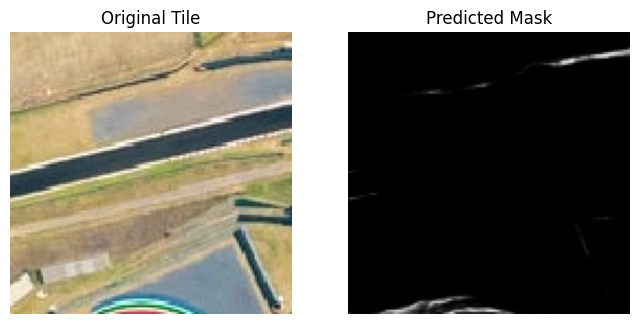

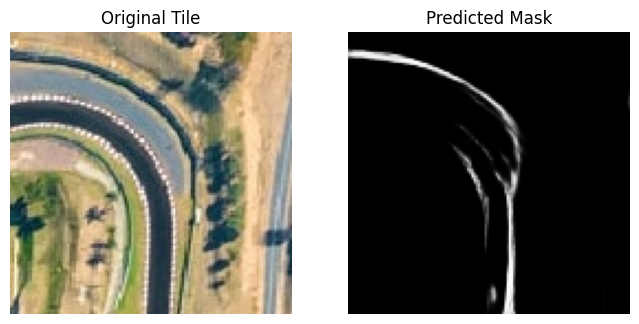

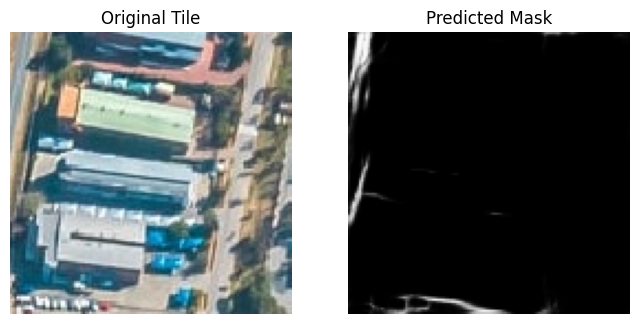

In [74]:
# Step 8: Predict on all tiles
predictions = []
for tile in tiles:
    tile_input = np.expand_dims(tile, axis=0)  # Add batch dimension
    pred = model.predict(tile_input, verbose=0)  # Disable progress bar
    predictions.append(pred)

# Step 9: Visualize first 10 predictions
for i in range(min(10, len(predictions))):
    visualize_results(predictions[i], tiles[i])


In [75]:
def stitch_tiles(tiles, image_size, tile_size=(128, 128)):
    """
    Stitches a list of tiles back into the original image size.

    Args:
        tiles (list of np.ndarray): List of tiles (predictions or images).
        image_size (tuple): (width, height) of the original image.
        tile_size (tuple): Size of each tile (width, height).

    Returns:
        np.ndarray: Stitched image.
    """
    width, height = image_size
    stitched = np.zeros((height, width), dtype=np.float32)  # for mask, 1 channel

    tile_idx = 0
    for y in range(0, height, tile_size[1]):
        for x in range(0, width, tile_size[0]):
            tile = tiles[tile_idx]

            # Ensure tile is 2D (mask only)
            if tile.ndim == 4:  # (1, H, W, 1)
                tile = tile[0, :, :, 0]
            elif tile.ndim == 3 and tile.shape[-1] == 1:  # (H, W, 1)
                tile = tile[:, :, 0]

            h = min(tile_size[1], height - y)
            w = min(tile_size[0], width - x)

            stitched[y:y+h, x:x+w] = tile[:h, :w]
            tile_idx += 1

    return stitched


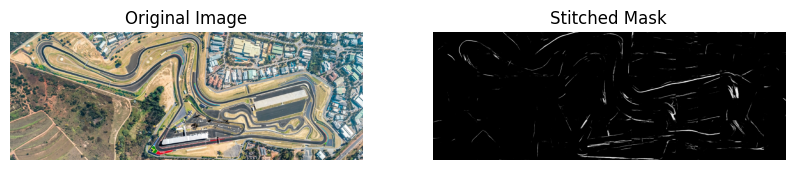

In [76]:
# Step 10: Stitch predictions back into full mask
original_size = original_image.size  # (width, height)
stitched_mask = stitch_tiles(predictions, original_size, (128, 128))

# Step 11: Show stitched result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(stitched_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Stitched Mask')
plt.axis('off')
plt.show()


In [77]:
def tile_image_large(image, crop_size=(246, 246), model_input_size=(128, 128)):
    """
    Splits an image into larger tiles and resizes them for the model.

    Args:
        image (PIL.Image or np.ndarray): Input image.
        crop_size (tuple): (width, height) of the crop from original image.
        model_input_size (tuple): Size to resize for the model.

    Returns:
        list: List of resized tiles (for model).
        list: List of original-sized tiles (for later upscaling mask).
    """
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    width, height = image.size
    resized_tiles = []
    original_tiles = []

    for y in range(0, height, crop_size[1]):
        for x in range(0, width, crop_size[0]):
            # Crop larger tile
            tile = image.crop((x, y, x + crop_size[0], y + crop_size[1]))

            # Pad if smaller
            if tile.size != crop_size:
                new_tile = Image.new("RGB", crop_size, (0, 0, 0))
                new_tile.paste(tile, (0, 0))
                tile = new_tile

            original_tiles.append(np.array(tile))  # Save original crop size
            resized_tile = tile.resize(model_input_size, Image.BILINEAR)
            resized_tiles.append(np.array(resized_tile))

    return resized_tiles, original_tiles


In [78]:
# Load and create tiles
resized_tiles, original_tiles = tile_image_large(original_image, crop_size=(246, 246), model_input_size=(128, 128))

predictions = []
for tile in resized_tiles:
    tile_input = np.expand_dims(tile, axis=0)
    pred = model.predict(tile_input, verbose=0)
    # Upscale back to crop size for stitching
    pred_upscaled = Image.fromarray(np.squeeze(pred) * 255).resize((246, 246), Image.BILINEAR)
    pred_upscaled = np.array(pred_upscaled) / 255.0
    predictions.append(pred_upscaled)


In [79]:
def stitch_tiles_large(tiles, image_size, crop_size=(246, 246)):
    width, height = image_size
    stitched = np.zeros((height, width), dtype=np.float32)

    tile_idx = 0
    for y in range(0, height, crop_size[1]):
        for x in range(0, width, crop_size[0]):
            h = min(crop_size[1], height - y)
            w = min(crop_size[0], width - x)
            stitched[y:y+h, x:x+w] = tiles[tile_idx][:h, :w]
            tile_idx += 1

    return stitched

stitched_mask = stitch_tiles_large(predictions, original_image.size, crop_size=(246, 246))


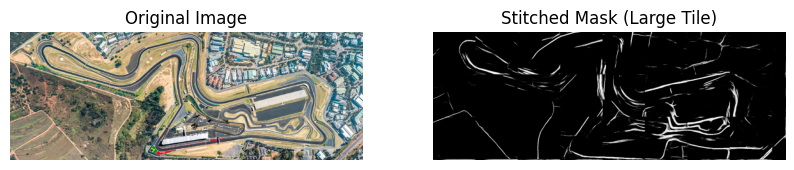

In [81]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(stitched_mask, cmap='gray', vmin=0, vmax=1)
plt.title('Stitched Mask (Large Tile)')
plt.axis('off')
plt.show()
